In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from pyro.distributions import Normal , HalfCauchy
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import NUTS, MCMC
from pyro.optim import Adam
import pyro.contrib.autoguide as auto

# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

%matplotlib inline

In [4]:
X = torch.randn((10000,))
a = torch.tensor(5.)
b = torch.tensor(2.)

noise = torch.randn((10000,))
data = a*X + b*X**2 + noise

In [5]:
def model(data , x):
    a_est = pyro.sample("a", Normal(loc=torch.zeros(1), scale=torch.ones(1)))
    b_est = pyro.sample('b' , Normal(loc=torch.zeros(1) , scale = torch.ones(1)))
    s2_est = pyro.sample("variance", HalfCauchy(loc=torch.zeros(1), scale=torch.ones(1)))
    curve = a_est * x + b_est * x**2
    y_hat = pyro.sample("yhat", Normal(loc= curve , scale=s2_est), obs=data)
    return y_hat

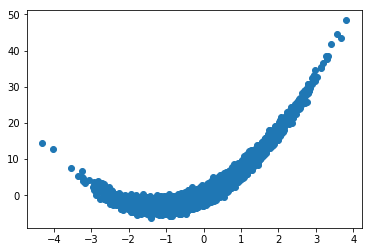

In [6]:
plt.scatter(X.numpy() , data.numpy())

In [7]:
# nuts_kernel = NUTS(model, adapt_step_size=True)
# mcmc_run = MCMC(nuts_kernel, num_samples=500, warmup_steps=100).run(X, data)

In [8]:
# a_posterior = pyro.infer.EmpiricalMarginal(mcmc_run, "a")
# b_posterior = pyro.infer.EmpiricalMarginal(mcmc_run, "b")
# plt.figure()
# figa = sns.distplot(a_posterior.get_samples_and_weights()[0])
# figa.set(xlabel = 'a')
# plt.figure()
# figb = sns.distplot(b_posterior.get_samples_and_weights()[0])
# figb.set(xlabel = 'b')
# plt.show()

In [16]:
guide = auto.AutoMultivariateNormal(model(data,X))

/Users/Rhys/anaconda3/lib/python3.6/site-packages/pyro/primitives.py:62: RuntimeWarning: trying to observe a value outside of inference at yhat
  RuntimeWarning)


In [17]:
adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(100):
    svi.step(data)
    if step % 10 == 0:
        print('.', end='')

TypeError: 'Tensor' object is not callable